# Ejemplo práctico: estimación de la precipitación en el valle de México usando datos de pluviómetros y radar meteorológico.

Autores: Daniel Vázquez-Ramírez$^{(1)}$ , Martín Díaz-Viera$^{(2)}$, Van Huong Le$^{(1)}$

1) Posgrado en Ciencias de la Tierra (UNAM)
2) Instituto Mexicano del Petróleo

# Introducción.
El siguiente ejemplo forma parte del artículo publicado por (Diaz,Et.Al,2009), donde se presenta una modificación del procedimiento geoestadístico de estimación espacial de la precipitación introducido por Krajewski (1987), el cual aplica el método de cokriging ordinario, combinando imágenes de radar meteorológico con datos de pluviómetros. Aquí, a diferencia del procedimiento de Krajewski, se incluye en el método de cokriging ordinario la dependencia espacial conjunta de radar-pluviómetros mediante un modelo de corregionalización lineal. La metodología propuesta es probada usando datos de pluviógrafos y de radar de una tormenta ocurrida en el valle de la ciudad de México.

## carga de funciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import pearsonr
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Carga de datos.
Ahora tenemos que cargar los datos de cada variable con su respectiva posición espacial en coordenadas UTM. Es importante que cada columna tenga su propio encabezado, así será fácil localizarlos e indexarlos. Para seleccionar el archive que contiene la información que necesitamos, ejecutamos el comando "pd.read_csv"

In [2]:
df = pd.read_csv(r"Data\lluvia.csv")

FileNotFoundError: ignored

Para ordenar los resultados necesitamos crear una carpeta que usemos específicamente para el análisis exploratorio de datos (AED), ahí se almacenarán tablas e imágenes

# Análisis exploratorio de datos.

Como se mostró en clase, el objetivo del análisis exploratorio es examinar las variables aleatorias disponibles y establecer si estas cumplen con los supuestos que requiere la estimación. Por lo tanto, es necesario verificar verificar su normalidad, linealidad, homocedasticidad, identificar los valores atípicos (outliers) y evaluar el impacto que tendrán estos valores durante el análisis variográfico y por supuesto, la estimación.

Para este ejemplo las variables son los valores obtenidos de los pluviómetros (Pluv_mm) y del radar meteorológico (Radar_mm), los cuales tienen una distribución espacial en coordenadas UTM.

In [ ]:
XCoord=df.UTM_X_m      #Coordenada UTM en x
YCoord=df.UTM_Y_m      #Coordenada UTM en y
Radar_mm=df.Radar_mm   #variable con la información del radar metereológico
Pluv_mm=df.Pluv_mm     #variable con la información de los pluviómetros

##  Análisis estadístico univariado.

Ya que tenemos las variables necesitamos saber sobre sus estadígrafos, esto lo podemos calcular usando la función "Estadisticas". Es importante mencionar que los valores calculados en este paso se usarán en los gráficos.

In [ ]:
def Estadisticas(x,lan):
    Stat1=x.describe()

    ran=max(x)-min(x)                            #range
    IQR=Stat1['75%']-Stat1['25%']
    var=x.var()                          #variance
    Skew=x.skew()                         #skewness
    curtosis=x.kurt()

    Stat=[]
    Stat.append(x.name)
    Stat.append(Stat1['count'])
    Stat.append(Stat1['min'])
    Stat.append(Stat1['25%'])
    Stat.append(Stat1['50%'])
    Stat.append(Stat1['mean'])
    Stat.append(Stat1['75%'])
    Stat.append(Stat1['max'])
    Stat.append(ran)
    Stat.append(IQR)
    Stat.append(var)
    Stat.append(Stat1['std'])
    Stat.append(Skew)
    Stat.append(curtosis)

    Stat=pd.Series(Stat)
    if lan=='esp':
        Stat.rename(index={0:'Estadisticas',1:'Muestras',2:'Mínimo',3:'1er cuartil',4:'Mediana',5:'Media', 6:'3er cuartil',
                           7: 'Máximo',8: 'Rango',9: 'Rango intercuartil', 10: 'Varianza', 11: 'Desviación estándar',
                           12:'Simetria', 13:'Curtosis'},inplace=True)
        #Stat.rename(columns={ 'Estadísticas' })
    if lan=='eng':
        Stat.rename(index={0:'Statistics',1:'Samples',2:'Minimum',3:'1st quartile',4:'Median',5:'Mean', 6:'3rd quartile',
                           7: 'Maximum',8: 'Range',9: 'IQR', 10: 'Variance', 11: 'STD',
                           12:'Skewness', 13:'Kurtosis'},inplace=True)

    return Stat

In [ ]:
XCoord_Stat=Estadisticas(XCoord,lan='esp')
print(XCoord_Stat)

Estadisticas                   UTM_X_m
Muestras                          50.0
Mínimo                        462178.0
1er cuartil                   474013.0
Mediana                       483728.0
Media                        483197.02
3er cuartil                   490282.0
Máximo                        504199.0
Rango                            42021
Rango intercuartil             16269.0
Varianza               104140556.46898
Desviación estándar       10204.928048
Simetria                      0.073892
Curtosis                     -0.655782
dtype: object


In [ ]:
YCoord_Stat=Estadisticas(YCoord,lan='esp')
print(YCoord_Stat)

Estadisticas                   UTM_Y_m
Muestras                          50.0
Mínimo                       2122836.0
1er cuartil                  2135024.0
Mediana                      2141102.0
Media                       2142667.72
3er cuartil                 2149392.25
Máximo                       2165983.0
Rango                            43147
Rango intercuartil            14368.25
Varianza               98894122.042449
Desviación estándar         9944.55238
Simetria                      0.208323
Curtosis                     -0.516714
dtype: object


In [ ]:
Radar_mm_Stat=Estadisticas(Radar_mm,lan='esp')
print(Radar_mm_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                     0.18
1er cuartil              0.8775
Mediana                   1.425
Media                     1.835
3er cuartil               2.375
Máximo                     7.79
Rango                      7.61
Rango intercuartil       1.4975
Varianza               2.473523
Desviación estándar    1.572744
Simetria               2.088088
Curtosis                5.66237
dtype: object


In [ ]:
Pluv_mm_Stat=Estadisticas(Pluv_mm,lan='esp')
print(Pluv_mm_Stat)

Estadisticas            Pluv_mm
Muestras                   50.0
Mínimo                     0.25
1er cuartil              0.3125
Mediana                     1.0
Media                      1.47
3er cuartil              1.9375
Máximo                     7.75
Rango                       7.5
Rango intercuartil        1.625
Varianza               2.575612
Desviación estándar    1.604871
Simetria               2.546323
Curtosis               7.944305
dtype: object


In [ ]:
def HistBoxplot(x,mean,median,bins,stat,color,xlab,lan):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                    gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x,orient='h',color=color,notch=True, ax=ax_box)
    ax_box.axvline(mean, ymin = 0, ymax = 1,color='red', linestyle = "dashed")
    ax_box.axvline(median, ymin = 0, ymax = 1,color='blue', linestyle = "dashed")
    sns.set_style("whitegrid", {'grid.linestyle': '-.'})
    sns.histplot(x, bins = bins,stat=stat,color=color, ax=ax_hist)
    ax_hist.axvline(mean, ymin = 0, ymax = 1,color='red', linestyle = "dashed")
    ax_hist.axvline(median, ymin = 0, ymax = 1,color='blue', linestyle = "dashed")
    plt.xlabel(xlab)
    if lan=='esp':
        plt.legend(labels=["Media", "Mediana"])
    if lan=='eng':
        plt.legend(labels=["Mean", "Median"])
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

### Análisis estadístico univariado para el radar meteorológico (Radar_mm).

El histograma con boxplot se grafica usando la función "HistBoxplot", esta necesita que le indiquemos el vector con los valores (x), el número de intervalos (bins) y el tipo de histograma(stat), el cual puede ser por conteo('count') o por frecuencia('frequency') y el color. En este curso se usan dos reglas: la regla de Sturges, propuesta por Herbert Sturges en 1926, cuya ecuación es

$$c=1+\frac{log(M)}{log(2)}=1+log_2(M)$$

Donde c es el número de clases o "bins" y M es el número de muestras. El logaritmo es base 10. Para usar esta regla se agrega al parámetro bins la linea 'sturges'

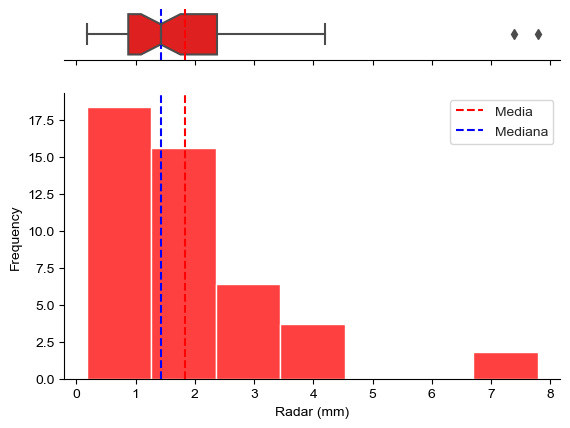

In [ ]:
HistBoxplot(x=Radar_mm,mean=Radar_mm_Stat[5],median=Radar_mm_Stat[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm)',lan='esp')

La regla de Sturges se recomienda para datos continuos con buena simetría, por lo que no es recomendable si las muestras presentan fuerte asimetría. Tampoco se recomienda si el número de muestras es menor a 30 ya que el resultado sería un histograma con pocos intervalos; si la muestra es muy grande puede derivar en histogramas sobresuavizados.

La regla de la raíz cuadrada simplemente requiere obtener la raíz cuadrada del número de muestras redondeado a un número entero, su ecuación es

$$c=\sqrt{(M)}$$

Para implementar esta regla en el histograma se agrega la linea 'sqrt' en el parametro bins.

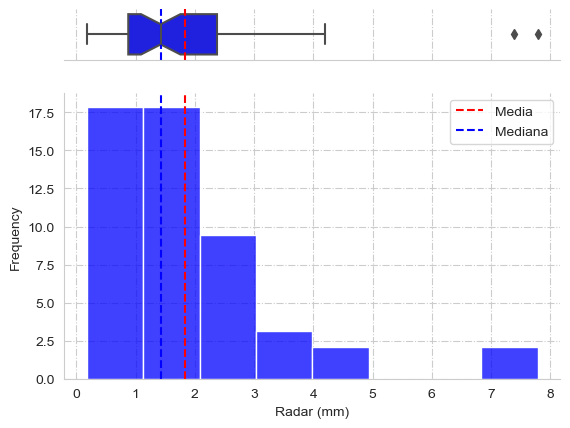

In [ ]:
HistBoxplot(Radar_mm, bins = "sqrt",mean=Radar_mm_Stat.iloc[5],median=Radar_mm_Stat.iloc[4],
            stat='frequency',color = "blue",xlab='Radar (mm)',lan='esp')

Otra opcion es la regla de Rice. Su formula es

$$c=2*\sqrt[3]{(M)}$$

Para implementar esta regla en el histograma se agrega la linea 'rice' en el parametro bins.

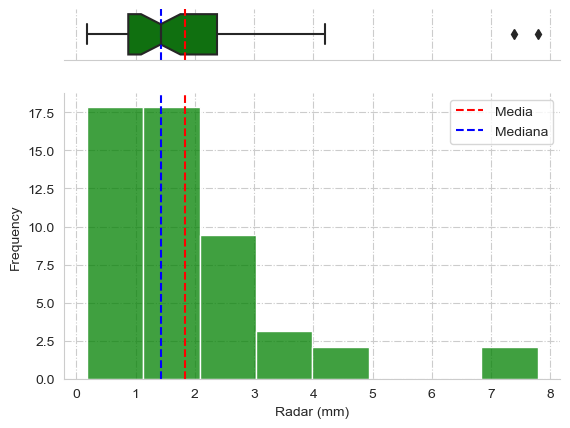

In [ ]:
HistBoxplot(Radar_mm, bins = "rice",mean=Radar_mm_Stat.iloc[5],median=Radar_mm_Stat.iloc[4],
            stat='frequency',color = "green",xlab='Radar (mm)',lan='esp')

El histograma para el radar meteorológico (Radar_mm) con frecuencia absoluta es:

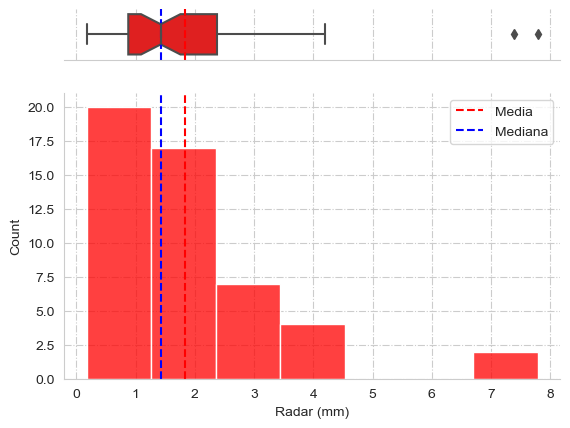

In [ ]:
HistBoxplot(x=Radar_mm,mean=Radar_mm_Stat.iloc[5],median=Radar_mm_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm)',lan='esp')

Y el histograma del radar meteorológico con frecuencia relativa es:

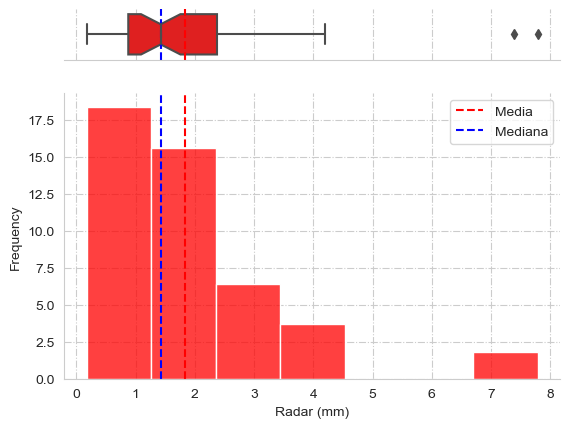

In [ ]:
HistBoxplot(x=Radar_mm,mean=Radar_mm_Stat.iloc[5],median=Radar_mm_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm)',lan='esp')

Analizando los histogramas y los estadígrafos de la variable del radar meteorológico (Radar_mm) tiene una diferencia entre la media y la mediana de 0.47, su coeficiente de asimetría es de 2.46929, lo cual significa que la variable es asimétrica. Esto se confirma con los histogramas, los cuales muestran que la asimetría es positiva. También podemos notar que el boxplot muestra dos valores atípicos localizados en el extremo derecho. El valor de la curtosis es de 7.99412, lo cual nos indica que es leptocúrtica.

Si deseamos obtener el gráfico Q-Q plot se usa la funcion "probplot", esta funcion pide la variable (Radar_mm), la distribucion de probabilidad, la cual es normal.

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([0.18, 0.19, 0.21, 0.24, 0.27, 0.43, 0.43, 0.5 , 0.51, 0.57, 0.62,
         0.67, 0.85, 0.96, 1.01, 1.04, 1.06, 1.17, 1.2 , 1.25, 1.27, 1.29,
         1.31, 1.31, 1.39, 1.46, 1.46, 1.5 , 1.62, 1.68, 1.86, 1.89, 1.92,
         1.97, 2.15, 2.24, 2.27, 

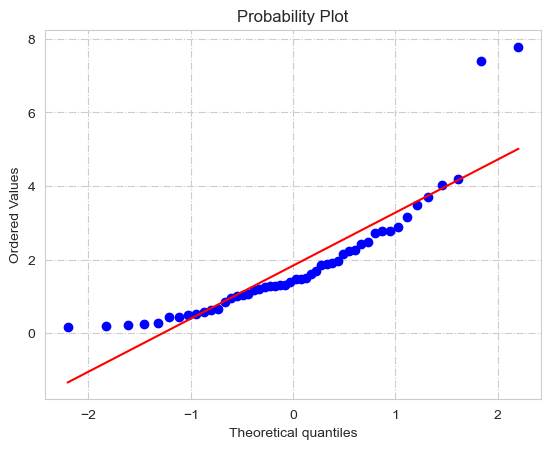

In [ ]:
stats.probplot(Radar_mm, dist="norm", plot=plt)

El siguiente paso es localizar y retirar los valores atipicos. Para saber cuáles son esos valores atípicos usamos la función "OutliersPos". Primero hay que crear un DataFrame que incluya las coordenadas y la variable (Radar_mm), para esto se usa la función "concat"

In [ ]:
Radar_mm_df=pd.concat([XCoord,YCoord,Radar_mm], axis=1)

In [ ]:
def OutliersPos(x):
    var=x.iloc[:, 2]
    Stat=Estadisticas(var,lan='esp')
    lim_inf=Stat.iloc[3]-(1.5*Stat.iloc[9])
    lim_sup=Stat.iloc[6]+(1.5*Stat.iloc[9])

    outliers=[]
    for i in range(len(var)):
        if var[i]<lim_inf or var[i]>lim_sup:
            out=x.iloc[i]
            outliers.append(out)
    outliers=pd.DataFrame(outliers)

    if len(outliers) <= 1:
       outliers="No hay valores atipicos/there's no outliers"
    return outliers

In [ ]:
OutliersPos(Radar_mm_df)

,UTM_X_m,UTM_Y_m,Radar_mm
31,482135.0,2129478.0,7.79
35,497898.0,2129469.0,7.39


El resultado indica que la muestra 31 y 35 son los valores atípicos, por lo tanto, se elimina esos valores de la variable creando una nueva variable que llamaremos "Radar_mm_df_out". También se calcula calcular los estadísticos para esta nueva variable.

NOTA: Eliminar los outliers no significa que no se usen más adelante, los valores atípicos son necesarios para saber si conviene o no eliminarlos y para la estimación del variograma, para ello se genera un nuevo vector. Por ejemplo, el vector "Radar_mm" es el vector original, el vector "Radar_mm_out" contiene todos los valores del vector original excepto aquellos que se marcaron como valores atípicos.

NOTA: Si desea utilizar el vector sin los valores atípicos, también deberá eliminar las coordenadas de los valores atípicos detectados, de lo contrario, no se podrá seguir con el análisis variográfico.

Para retirar los valores atípicos y sus coordenadas se usa la funcion "RemoveOutliersPos", la cual solo necesita el DataFrame que contiene la variable y sus coordenadas.

In [ ]:
def RemoveOutliersPos(x):
    var=x.iloc[:, 2]
    Stat=Estadisticas(var,lan='esp')
    lim_inf=Stat.iloc[3]-(1.5*Stat.iloc[9])
    lim_sup=Stat.iloc[6]+(1.5*Stat.iloc[9])

    Noutliers=[]
    for i in range(len(var)):
        if var[i]>=lim_inf and var[i]<=lim_sup:
            acce=x.iloc[i]
            Noutliers.append(acce)
    Noutliers=pd.DataFrame(Noutliers)
    Noutliers.reset_index(drop=True, inplace=True)
    return Noutliers

In [ ]:
Radar_mm_df_out=RemoveOutliersPos(Radar_mm_df)
print(Radar_mm_df_out)

     UTM_X_m    UTM_Y_m  Radar_mm
0   485303.0  2162682.0      1.29
1   484253.0  2157150.0      2.48
2   487403.0  2154937.0      2.79
3   490552.0  2153830.0      1.06
4   489502.0  2151601.0      2.88
5   480054.0  2157142.0      1.62
6   481104.0  2154828.0      2.41
7   483203.0  2152713.0      2.15
8   475855.0  2149399.0      1.89
9   486353.0  2148284.0      2.24
10  482155.0  2149394.0      1.31
11  492651.0  2147174.0      0.57
12  494751.0  2149386.0      0.27
13  477955.0  2144973.0      2.73
14  472694.0  2140554.0      0.67
15  473739.0  2137233.0      2.77
16  481095.0  2139437.0      3.15
17  482154.0  2144968.0      1.46
18  486348.0  2141645.0      2.27
19  471645.0  2141662.0      1.25
20  468489.0  2138348.0      0.43
21  462178.0  2133934.0      0.18
22  474787.0  2135019.0      1.17
23  472682.0  2132809.0      0.43
24  485294.0  2137220.0      3.49
25  491597.0  2138323.0      1.20
26  504199.0  2136108.0      1.27
27  497899.0  2133895.0      1.39
28  498949.0  

Para estimar los valores estadisticos de esta nueva muestra se debe estraer la variable del DataFrame. Para esto se usa la funcion "iloc".

In [ ]:
Radar_mm_out=Radar_mm_df_out.iloc[:,2]
Radar_mm_out_Stat=Estadisticas(Radar_mm_out,lan='esp')
print(Radar_mm_out_Stat)

Estadisticas           Radar_mm
Muestras                   48.0
Mínimo                     0.18
1er cuartil               0.805
Mediana                    1.35
Media                  1.595208
3er cuartil              2.2475
Máximo                     4.19
Rango                      4.01
Rango intercuartil       1.4425
Varianza               1.108991
Desviación estándar    1.053087
Simetria               0.716246
Curtosis              -0.117107
dtype: object


Se vuelve a graficar el histograma para los valores obtenidos con el radar meteorológico sin valores atípicos (Radar_mm_out) con frecuencia absoluta.

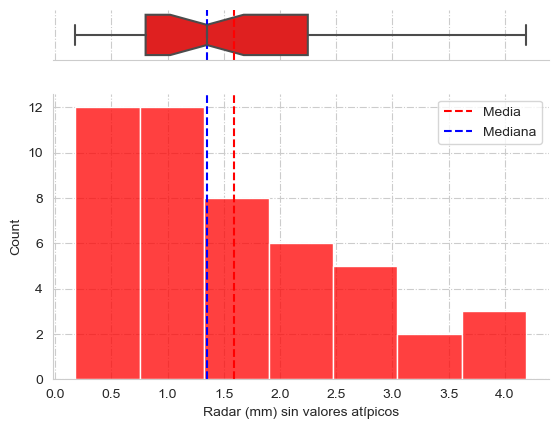

In [ ]:
HistBoxplot(x=Radar_mm_out,mean=Radar_mm_out_Stat.iloc[5],median=Radar_mm_out_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) sin valores atípicos',lan='esp')

Y el histograma para los valores obtenidos con el radar meteorológico sin valores atípicos (Radar_mm_out) con frecuencia relativa.

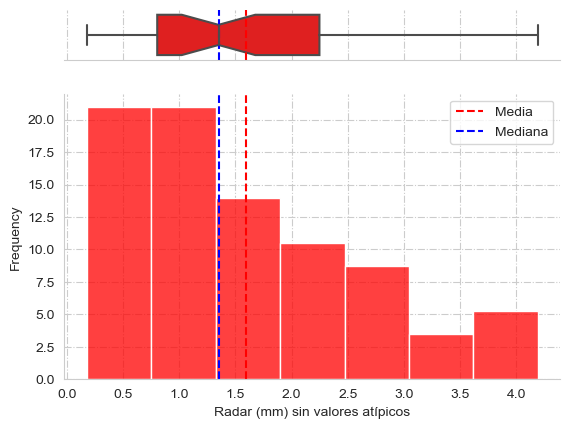

In [ ]:
HistBoxplot(x=Radar_mm_out,mean=Radar_mm_out_Stat.iloc[5],median=Radar_mm_out_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) sin valores atípicos',lan='esp')

Analizando la diferencia entre la media y la mediana de esta nueva variable es de 0.2452 y su asimetría es de 0.716246. En principio esto nos indica que la asimetría disminuyó, sin embargo, la variable sigue mostrando asimetría positiva. Con el caso de la curtosis, el valor pasó de 5.66237 a -0.117107, con lo cual consideramos que es planicúrtica.

Ahora podemos observar que los boxplot no muestran nuevos valores atípicos para la variable del radar meteorológico sin valores atípicos (Radar_mm_out). Esto lo podemos confirmar usando la función "OutliersPos".

In [ ]:
OutliersPos(Radar_mm_df_out)

"No hay valores atipicos/there's no outliers"

#### Transformación de variable para el radar meteorológico (Radar_mm).

Dado que no se logró obtener la normalidad en esta variable, podemos usar alguna transformación.

En estadística, la transformación de datos es la aplicación de una función matemática determinista a cada punto en un conjunto de datos, es decir, cada punto de datos $z_i$ se reemplaza con el valor transformado $y_i=f(z_i)$, donde $f$ es una función.

Las transformaciones generalmente se aplican para que los datos parezcan cumplir más con los supuestos de un procedimiento de inferencia estadística que se aplicará o para mejorar la interpretabilidad o la apariencia de los gráficos.

Las razones más comunes para aplicar una transformación son:

* Reducir la asimetría.
* Lograr relaciones de dependencia lineales o cuasi lineales
* Conveniencia.

Las transformaciones más comunes son:

Para Asimetrías positivas:

* Raíz cuadrada $v_{at}=\sqrt{v_a}$

* Logarítmica  $v_{at}=Log(v_a)$

* Recíproca  $v_{at}=\frac{1}{v_a}$

Para asimetrías negativas:

* Potencias  $v_{at}=v_a^n$

* Arcseno $v_{at}=arcsen(v_a)$

* Exponencial  $v_{at}=exp(v_a)$


Donde ${v_a}$ es la variable aleatoria y $v_{at}$ es la variable aleatoria transformada.

$\textbf{NOTA: El usuario debe saber si la transformación puede ser usada en la variable aleatoria}$. Por ejemplo, si la variable aleatoria contiene muestras con valor cero, entonces no podrá usar las transformaciones logarítmica o reciproca. Si desea usar la transformación arcseno, la variable aleatoria debe tener componente trigonométrica.

Dado que la variable del radar meteorológico (Radar_mm) presenta asimetría positiva, se van a usar dos tipos de transformaciones: raíz cuadrada y logarítmica.

$\textbf{Transformación de raíz cuadrada}$

Empezaremos con la transformación de raíz cuadrada usando el vector "Radar_mm", la cual se hace de la siguiente forma:

In [ ]:
Radar_mm_Sqrt=np.sqrt(Radar_mm)

Ya que obtenemos la variable aleatoria transformada por raíz cuadrada (Radar_mm_Sqrt), debemos obtener sus estadígrafos.

In [ ]:
Radar_mm_Sqrt_Stat=Estadisticas(Radar_mm_Sqrt,lan='esp')
print(Radar_mm_Sqrt_Stat,Radar_mm_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                 0.424264
1er cuartil            0.936415
Mediana                1.193644
Media                   1.25106
3er cuartil            1.540976
Máximo                 2.791057
Rango                  2.366793
Rango intercuartil     0.604561
Varianza               0.275356
Desviación estándar    0.524743
Simetria               0.772774
Curtosis               1.093447
dtype: object Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                     0.18
1er cuartil              0.8775
Mediana                   1.425
Media                     1.835
3er cuartil               2.375
Máximo                     7.79
Rango                      7.61
Rango intercuartil       1.4975
Varianza               2.473523
Desviación estándar    1.572744
Simetria               2.088088
Curtosis                5.66237
dtype: object


Y graficamos los histogramas con frecuencia absoluta y relativa de la transformación raíz cuadrada.

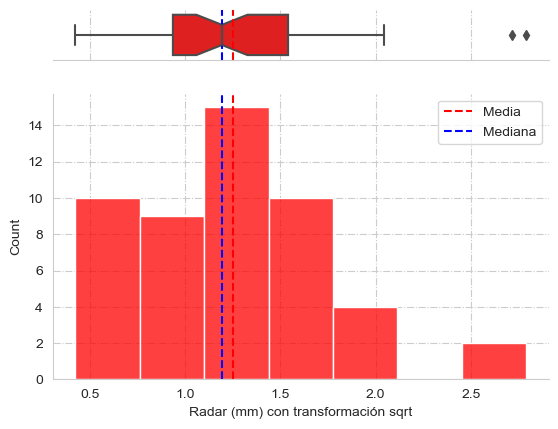

In [ ]:
HistBoxplot(x=Radar_mm_Sqrt,mean=Radar_mm_Sqrt_Stat.iloc[5],median=Radar_mm_Sqrt_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) con transformación sqrt',lan='esp')

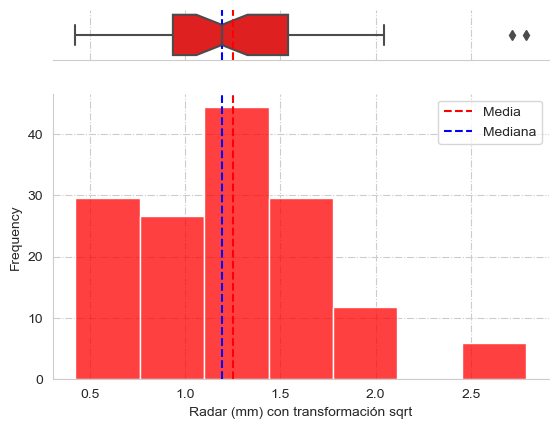

In [ ]:
HistBoxplot(x=Radar_mm_Sqrt,mean=Radar_mm_Sqrt_Stat.iloc[5],median=Radar_mm_Sqrt_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) con transformación sqrt',lan='esp')

Si observamos la diferencia entre la media y la mediana de la variable transformada (Radar_mm_Sqrt) podemos notar que es de 0.05742, lo cual podemos considerar como muy bajo en comparación de la diferencia obtenida de la variable sin transformar que es de 0.47, sin embargo, observamos que el boxplot muestra la presencia de dos valores atípicos, los cuales debemos retirar y verificar que no afecten la supuesta simetría que hemos logrado con la transformación.

In [ ]:
Radar_mm_Sqrt_df=pd.concat([XCoord,YCoord,Radar_mm_Sqrt], axis=1)
OutliersPos(Radar_mm_Sqrt_df)

,UTM_X_m,UTM_Y_m,Radar_mm
31,482135.0,2129478.0,2.791057
35,497898.0,2129469.0,2.718455


Ahora que se sabe cuáles son los valores atípicos, se debe generar una nueva tabla para retirar los valores atípicos junto con sus coordenadas, para esto se usan las siguientes líneas:

In [ ]:
Radar_mm_Sqrt_df_out=RemoveOutliersPos(Radar_mm_Sqrt_df)
print(Radar_mm_Sqrt_df_out)

     UTM_X_m    UTM_Y_m  Radar_mm
0   485303.0  2162682.0  1.135782
1   484253.0  2157150.0  1.574802
2   487403.0  2154937.0  1.670329
3   490552.0  2153830.0  1.029563
4   489502.0  2151601.0  1.697056
5   480054.0  2157142.0  1.272792
6   481104.0  2154828.0  1.552417
7   483203.0  2152713.0  1.466288
8   475855.0  2149399.0  1.374773
9   486353.0  2148284.0  1.496663
10  482155.0  2149394.0  1.144552
11  492651.0  2147174.0  0.754983
12  494751.0  2149386.0  0.519615
13  477955.0  2144973.0  1.652271
14  472694.0  2140554.0  0.818535
15  473739.0  2137233.0  1.664332
16  481095.0  2139437.0  1.774824
17  482154.0  2144968.0  1.208305
18  486348.0  2141645.0  1.506652
19  471645.0  2141662.0  1.118034
20  468489.0  2138348.0  0.655744
21  462178.0  2133934.0  0.424264
22  474787.0  2135019.0  1.081665
23  472682.0  2132809.0  0.655744
24  485294.0  2137220.0  1.868154
25  491597.0  2138323.0  1.095445
26  504199.0  2136108.0  1.126943
27  497899.0  2133895.0  1.178983
28  498949.0  

Se calculan los estadígrafos

In [ ]:
Radar_mm_Sqrt_out=Radar_mm_Sqrt_df_out.iloc[:,2]
Radar_mm_Sqrt_out_Stat=Estadisticas(Radar_mm_Sqrt_out,lan='esp')
print(Radar_mm_Sqrt_Stat,Radar_mm_Sqrt_out_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                 0.424264
1er cuartil            0.936415
Mediana                1.193644
Media                   1.25106
3er cuartil            1.540976
Máximo                 2.791057
Rango                  2.366793
Rango intercuartil     0.604561
Varianza               0.275356
Desviación estándar    0.524743
Simetria               0.772774
Curtosis               1.093447
dtype: object Estadisticas           Radar_mm
Muestras                   48.0
Mínimo                 0.424264
1er cuartil              0.8961
Mediana                1.161767
Media                  1.188406
3er cuartil             1.49916
Máximo                 2.046949
Rango                  1.622685
Rango intercuartil     0.603061
Varianza               0.186791
Desviación estándar    0.432193
Simetria               0.028182
Curtosis              -0.675449
dtype: object


Con los resultados obtenidos al retirar los dos valores atípicos podemos notar que la diferencia entre la media y la mediana pasaron de  0.05742 a 0.0266, podemos considerar que la transformación cumplió su propósito al reducir de manera significativa la asimetría, sin embargo, comparando las muestras transformadas con y sin valores atípicos podría no justificar el retiro de los valores atípicos ya que es muy pequeña la diferencia.

Y graficamos sus histogramas.

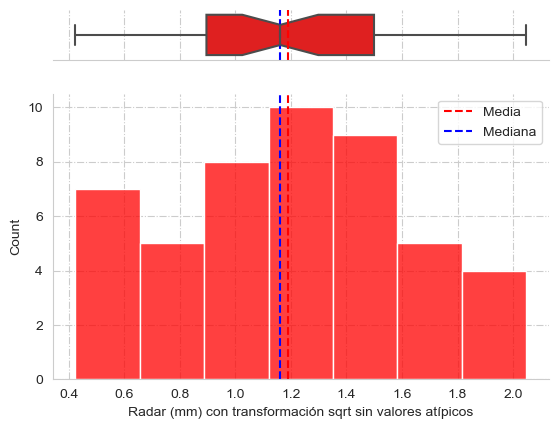

In [ ]:
HistBoxplot(x=Radar_mm_Sqrt_out,mean=Radar_mm_Sqrt_out_Stat.iloc[5],median=Radar_mm_Sqrt_out_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) con transformación sqrt sin valores atípicos',lan='esp')

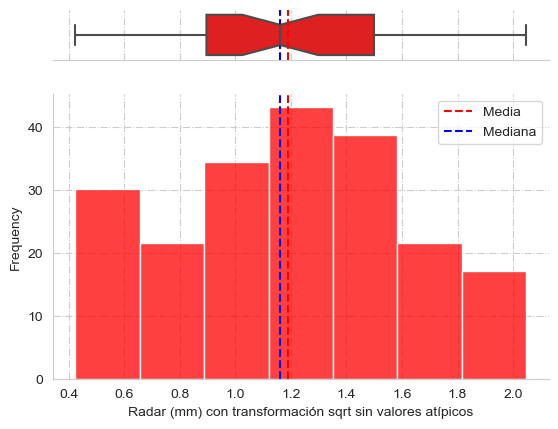

In [ ]:
HistBoxplot(x=Radar_mm_Sqrt_out,mean=Radar_mm_Sqrt_out_Stat.iloc[5],median=Radar_mm_Sqrt_out_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) con transformación sqrt sin valores atípicos',lan='esp')

$\textbf{Transformación logarítmica}$

Ahora probaremos usando la transformación logarítmica. La cual se hace de la siguiente forma:

In [ ]:
Radar_mm_Log=np.log(Radar_mm)

y al igual que la transformada por raíz cuadrada, obtenemos sus valores estadísticos.

In [ ]:
Radar_mm_Log_Stat=Estadisticas(Radar_mm_Log,lan='esp')
print(Radar_mm_Log_Stat,Radar_mm_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                -1.714798
1er cuartil           -0.132095
Mediana                 0.35387
Media                  0.265693
3er cuartil            0.864665
Máximo                 2.052841
Rango                  3.767639
Rango intercuartil      0.99676
Varianza               0.797756
Desviación estándar    0.893172
Simetria              -0.475429
Curtosis              -0.011404
dtype: object Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                     0.18
1er cuartil              0.8775
Mediana                   1.425
Media                     1.835
3er cuartil               2.375
Máximo                     7.79
Rango                      7.61
Rango intercuartil       1.4975
Varianza               2.473523
Desviación estándar    1.572744
Simetria               2.088088
Curtosis                5.66237
dtype: object


Y graficamos sus respectivos histogramas.

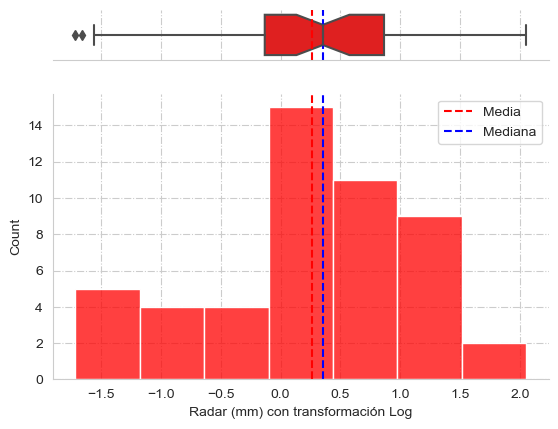

In [ ]:
HistBoxplot(x=Radar_mm_Log,mean=Radar_mm_Log_Stat.iloc[5],median=Radar_mm_Log_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) con transformación Log',lan='esp')

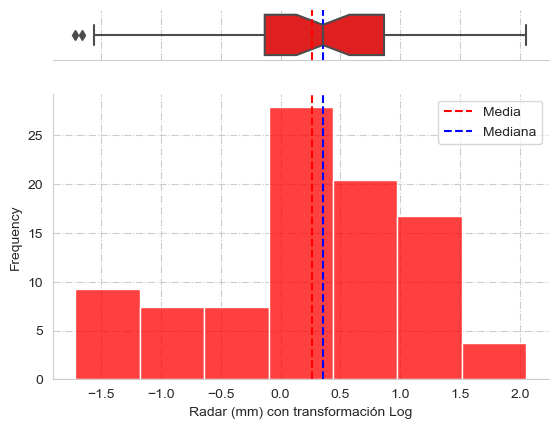

In [ ]:
HistBoxplot(x=Radar_mm_Log,mean=Radar_mm_Log_Stat.iloc[5],median=Radar_mm_Log_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) con transformación Log',lan='esp')

La diferencia entre la media y la mediana de la transformación logarítmica es de 0.08818, de forma aparente esta diferencia es mayor comparada con la transformación por raíz cuadrada. El boxplot indica que existen valores atípicos.

In [ ]:
Radar_mm_Log_df=pd.concat([XCoord,YCoord,Radar_mm_Log], axis=1)
OutliersPos(Radar_mm_Log_df)

,UTM_X_m,UTM_Y_m,Radar_mm
21,462178.0,2133934.0,-1.714798
48,503149.0,2123937.0,-1.660731


Retiramos los valores atipicos

In [ ]:
Radar_mm_Log_df_out=RemoveOutliersPos(Radar_mm_Log_df)
print(Radar_mm_Log_df_out)

     UTM_X_m    UTM_Y_m  Radar_mm
0   485303.0  2162682.0  0.254642
1   484253.0  2157150.0  0.908259
2   487403.0  2154937.0  1.026042
3   490552.0  2153830.0  0.058269
4   489502.0  2151601.0  1.057790
5   480054.0  2157142.0  0.482426
6   481104.0  2154828.0  0.879627
7   483203.0  2152713.0  0.765468
8   475855.0  2149399.0  0.636577
9   486353.0  2148284.0  0.806476
10  482155.0  2149394.0  0.270027
11  492651.0  2147174.0 -0.562119
12  494751.0  2149386.0 -1.309333
13  477955.0  2144973.0  1.004302
14  472694.0  2140554.0 -0.400478
15  473739.0  2137233.0  1.018847
16  481095.0  2139437.0  1.147402
17  482154.0  2144968.0  0.378436
18  486348.0  2141645.0  0.819780
19  471645.0  2141662.0  0.223144
20  468489.0  2138348.0 -0.843970
21  474787.0  2135019.0  0.157004
22  472682.0  2132809.0 -0.843970
23  485294.0  2137220.0  1.249902
24  491597.0  2138323.0  0.182322
25  504199.0  2136108.0  0.239017
26  497899.0  2133895.0  0.329304
27  498949.0  2131682.0  1.393766
28  480038.0  

In [ ]:
Radar_mm_Log_out=Radar_mm_Log_df_out.iloc[:,2]
Radar_mm_Log_out_Stat=Estadisticas(Radar_mm_Log_out,lan='esp')
print(Radar_mm_Log_Stat,Radar_mm_Log_out_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                -1.714798
1er cuartil           -0.132095
Mediana                 0.35387
Media                  0.265693
3er cuartil            0.864665
Máximo                 2.052841
Rango                  3.767639
Rango intercuartil      0.99676
Varianza               0.797756
Desviación estándar    0.893172
Simetria              -0.475429
Curtosis              -0.011404
dtype: object Estadisticas           Radar_mm
Muestras                   48.0
Mínimo                -1.560648
1er cuartil           -0.002743
Mediana                0.378436
Media                  0.347087
3er cuartil            0.886785
Máximo                 2.052841
Rango                  3.613489
Rango intercuartil     0.889527
Varianza               0.662523
Desviación estándar    0.813955
Simetria               -0.35601
Curtosis               0.113624
dtype: object


Y graficamos sus histogramas:

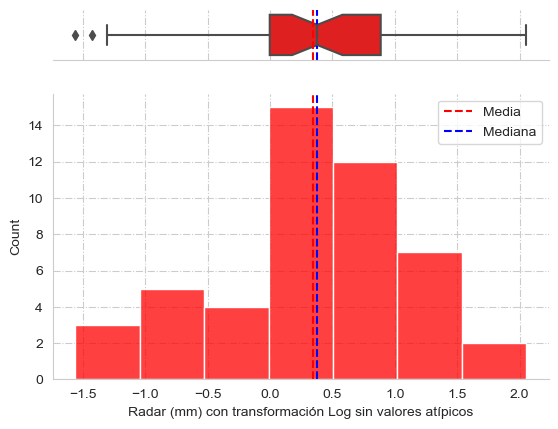

In [ ]:
HistBoxplot(x=Radar_mm_Log_out,mean=Radar_mm_Log_out_Stat.iloc[5],median=Radar_mm_Log_out_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) con transformación Log sin valores atípicos',lan='esp')

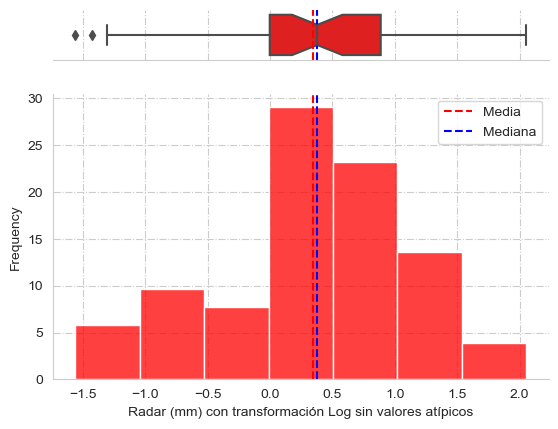

In [ ]:
HistBoxplot(x=Radar_mm_Log_out,mean=Radar_mm_Log_out_Stat.iloc[5],median=Radar_mm_Log_out_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) con transformación Log sin valores atípicos',lan='esp')

La diferencia entre la media y la mediana de la transformación logarítmica quitando los valores atípicos detectados pasó de 0.08818 a 0.0313, sin embargo, el boxplot muestran dos valores atípicos localizados a la izquierda del gráfico. Por lo tanto, retiraremos esos nuevos valores atípicos.

In [ ]:
OutliersPos(Radar_mm_Log_df_out)

,UTM_X_m,UTM_Y_m,Radar_mm
44,467433.0,2135030.0,-1.427116
47,472686.0,2135022.0,-1.560648


Retiramos los valores atipicos

In [ ]:
Radar_mm_Log_df_out2=RemoveOutliersPos(Radar_mm_Log_df_out)
print(Radar_mm_Log_df_out2)

     UTM_X_m    UTM_Y_m  Radar_mm
0   485303.0  2162682.0  0.254642
1   484253.0  2157150.0  0.908259
2   487403.0  2154937.0  1.026042
3   490552.0  2153830.0  0.058269
4   489502.0  2151601.0  1.057790
5   480054.0  2157142.0  0.482426
6   481104.0  2154828.0  0.879627
7   483203.0  2152713.0  0.765468
8   475855.0  2149399.0  0.636577
9   486353.0  2148284.0  0.806476
10  482155.0  2149394.0  0.270027
11  492651.0  2147174.0 -0.562119
12  494751.0  2149386.0 -1.309333
13  477955.0  2144973.0  1.004302
14  472694.0  2140554.0 -0.400478
15  473739.0  2137233.0  1.018847
16  481095.0  2139437.0  1.147402
17  482154.0  2144968.0  0.378436
18  486348.0  2141645.0  0.819780
19  471645.0  2141662.0  0.223144
20  468489.0  2138348.0 -0.843970
21  474787.0  2135019.0  0.157004
22  472682.0  2132809.0 -0.843970
23  485294.0  2137220.0  1.249902
24  491597.0  2138323.0  0.182322
25  504199.0  2136108.0  0.239017
26  497899.0  2133895.0  0.329304
27  498949.0  2131682.0  1.393766
28  480038.0  

In [ ]:
Radar_mm_Log_out2=Radar_mm_Log_df_out2.iloc[:,2]
Radar_mm_Log_out2_Stat=Estadisticas(Radar_mm_Log_out2,lan='esp')
print(Radar_mm_Log_Stat,Radar_mm_Log_out_Stat,Radar_mm_Log_out2_Stat)

Estadisticas           Radar_mm
Muestras                   50.0
Mínimo                -1.714798
1er cuartil           -0.132095
Mediana                 0.35387
Media                  0.265693
3er cuartil            0.864665
Máximo                 2.052841
Rango                  3.767639
Rango intercuartil      0.99676
Varianza               0.797756
Desviación estándar    0.893172
Simetria              -0.475429
Curtosis              -0.011404
dtype: object Estadisticas           Radar_mm
Muestras                   48.0
Mínimo                -1.560648
1er cuartil           -0.002743
Mediana                0.378436
Media                  0.347087
3er cuartil            0.886785
Máximo                 2.052841
Rango                  3.613489
Rango intercuartil     0.889527
Varianza               0.662523
Desviación estándar    0.813955
Simetria               -0.35601
Curtosis               0.113624
dtype: object Estadisticas           Radar_mm
Muestras                   46.0
Mínimo      

Y graficamos sus histogramas:

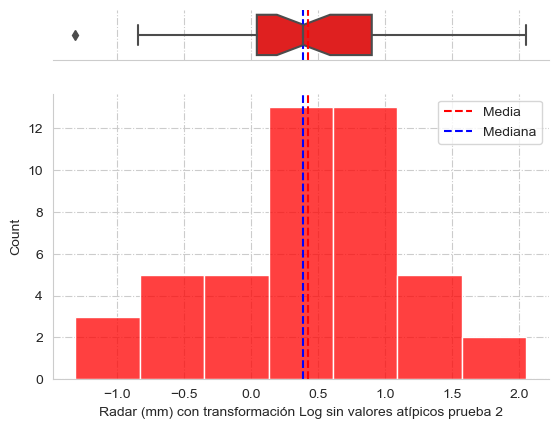

In [ ]:
HistBoxplot(x=Radar_mm_Log_out2,mean=Radar_mm_Log_out2_Stat.iloc[5],median=Radar_mm_Log_out2_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Radar (mm) con transformación Log sin valores atípicos prueba 2',lan='esp')

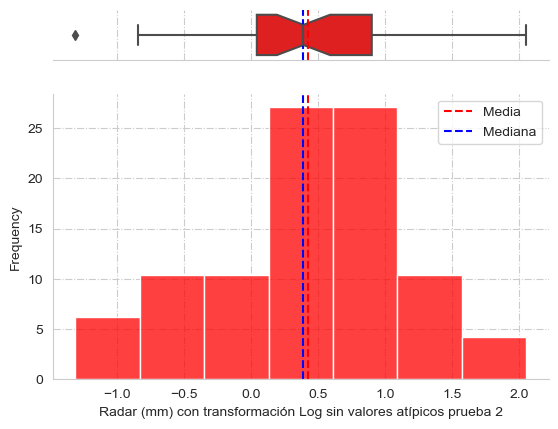

In [ ]:
HistBoxplot(x=Radar_mm_Log_out2,mean=Radar_mm_Log_out2_Stat.iloc[5],median=Radar_mm_Log_out2_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Radar (mm) con transformación Log sin valores atípicos prueba 2',lan='esp')

La diferencia entre la media y la mediana de la transformación logarítmica quitando los valores atípicos detectados pasó de 0.0313 a 0.0351, es decir, aumentó el valor, sin ser significativo este aumento, con lo cual podemos considerar que hacer el segundo retiro de valores atípicos es innecesario.

### Análisis estadístico univariado para los datos obtenidos de pluviómetros (Pluv_mm).

Ahora se hace el mismo análisis estadístico a los datos obtenidos de los pluviómetros (Pluv_mm). Empezamos obteniendo los valores estadísticos.

In [ ]:
Pluv_mm_Stat=Estadisticas(Pluv_mm,lan='esp')
print(Pluv_mm_Stat)

Estadisticas            Pluv_mm
Muestras                   50.0
Mínimo                     0.25
1er cuartil              0.3125
Mediana                     1.0
Media                      1.47
3er cuartil              1.9375
Máximo                     7.75
Rango                       7.5
Rango intercuartil        1.625
Varianza               2.575612
Desviación estándar    1.604871
Simetria               2.546323
Curtosis               7.944305
dtype: object


Y su respectivo histograma.

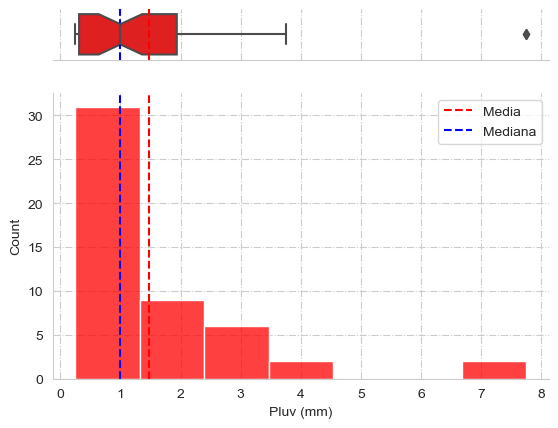

In [ ]:
HistBoxplot(x=Pluv_mm,mean=Pluv_mm_Stat.iloc[5],median=Pluv_mm_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Pluv (mm)',lan='esp')

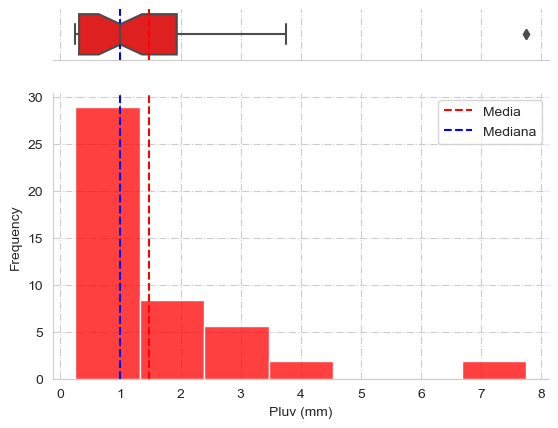

In [ ]:
HistBoxplot(x=Pluv_mm,mean=Pluv_mm_Stat.iloc[5],median=Pluv_mm_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Pluv (mm)',lan='esp')

Se puede notar que la diferencia entre la media y la mediana es de 0.47, lo cual nos indica que la variable es asimétrica positiva y el histograma nos confirma esta información.

$\textbf{Transformación logarítmica.}$

Analizando el histograma se observa un fuerte crecimiento en la parte izquierda, por lo tanto es recomendable usar la transformación logarítmica.

In [ ]:
Pluv_mm_Log=np.log(Pluv_mm)
Pluv_mm_Log_Stat=Estadisticas(Pluv_mm_Log,lan='esp')
print(Pluv_mm_Log_Stat)

Estadisticas            Pluv_mm
Muestras                   50.0
Mínimo                -1.386294
1er cuartil           -1.213008
Mediana                     0.0
Media                  -0.09031
3er cuartil            0.659764
Máximo                 2.047693
Rango                  3.433987
Rango intercuartil     1.872772
Varianza               1.000447
Desviación estándar    1.000223
Simetria               0.115897
Curtosis              -0.964136
dtype: object


Los histogramas de la transformación logarítmica son los siguientes:

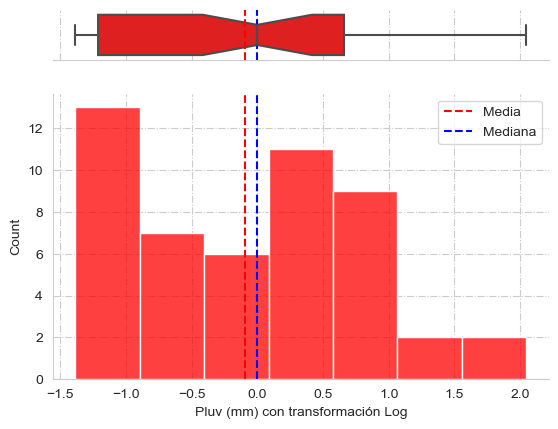

In [ ]:
HistBoxplot(x=Pluv_mm_Log,mean=Pluv_mm_Log_Stat.iloc[5],median=Pluv_mm_Log_Stat.iloc[4], bins = "sturges",
            stat='count',color = "red",xlab='Pluv (mm) con transformación Log',lan='esp')

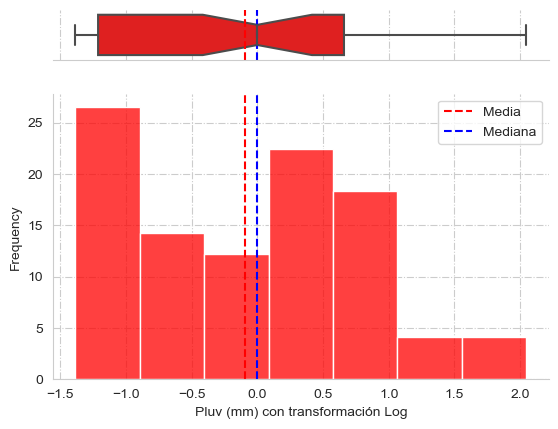

In [ ]:
HistBoxplot(x=Pluv_mm_Log,mean=Pluv_mm_Log_Stat.iloc[5],median=Pluv_mm_Log_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Pluv (mm) con transformación Log',lan='esp')

La diferencia entre la media y la mediana pasó de 0.47 a 0.09, lo cual es bajo. El boxplot no muestra valores atípicos, sin embargo, nos aseguraremos que esto sea cierto usando la función "OutliersPos".


In [ ]:
Pluv_mm_Log_df=pd.concat([XCoord,YCoord,Pluv_mm_Log], axis=1)
OutliersPos(Pluv_mm_Log_df)

"No hay valores atipicos/there's no outliers"

No se encontraron valores atípicos, por lo tanto, aquí se termina el análisis univariado de esta variable.

## Análisis estadístico bivariado.

Como pudimos notar durante el análisis exploratorio univariado, necesitamos de dos elementos para interpretar las características estadísticas de una variable: un histograma y una tabla con los valores estadísticos. Con el caso del análisis exploratorio bivariado necesitamos un diagrama de dispersión o scatterplot y los grados de dependencia.

Un diagrama de dispersión es una gráfica compuesta por pares de valores de dos variables aleatorias $(x_i,y_i)$.

Los grados de dependencia se miden usando el coeficiente de correlación lineal de Pearson:

$$\rho_{XY}=\frac{\sigma_{XY}}{\sigma_{X}\sigma_{Y}}==\frac{Cov(X,Y)}{\sqrt(Var(X)Var(Y))}$$

El coeficiente de correlación de Spearman:

$$\rho=1-\frac{6\sum{D^2}}{N(N^2-1)}$$

Y el coeficiente de correlación de Kendall:

$$\tau=\frac{{\textit{número de pares concordantes − número de pares discordantes}}}{\bigl(\begin{smallmatrix}n\\ 2\end{smallmatrix}\bigr)}$$

### Cálculo de grados de dependencia

Para calcular las medidas de dependencia usamos la función "cor", esta necesita tres elementos: dos variables, en este caso (Radar_mm , Pluv_mm) y el método que se desea usar, este puede ser Pearson, Spearman o Kendall.

In [ ]:
Radar_mm.corr(Pluv_mm, method = "pearson")

0.9410484882345729

In [ ]:
Radar_mm.corr(Pluv_mm, method = "spearman")

0.8480453004301345

In [ ]:
Radar_mm.corr(Pluv_mm, method = "kendall")

0.7187150842385326

Respecto al coeficiente de Pearson, su valor es de 0.9410, lo cual podemos considerar como cuasi-lineal. Sin embargo, los valores de la correlación de Spearman (0.8480) y Kendall (0.7187) indican que el modelo no es cuasi-lineal, por lo que es posible que la dependencia lineal esté alterada por valores atípicos.

### Diagrama de dispersión.

El diagrama de dispersión se grafica usando la función "joinplot", esta función requiere de los siguientes parámetros:

* Variables (Radar_mm , Pluv_mm)
* Número de intervalos para los histogramas, en este caso se usa la regla de sturges
* Leyendas para el eje X (xlab) y el eje Y (ylab)

In [ ]:
def ScatterPlot(x,y,xlab,ylab,bins,color):
    data_pair=pd.concat([x,y], axis=1)
    g=sns.jointplot(x=data_pair.iloc[:,0],y=data_pair.iloc[:,1],data=data_pair,kind='scatter',
                    color=color,marginal_kws=dict(bins=bins,color='blue'))
    p = x.corr(y, method = "pearson")
    r = x.corr(y, method = "spearman")
    k = x.corr(y, method = "kendall")
    g.ax_joint.annotate(f'$Pearson = {p:.4f}$',
                    xy=(1.03, 1.2), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(f'$Spearman = {r:.4f}$',
                    xy=(1.03, 1.13), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(f'$Kendall={k:.4f}$',
                    xy=(1.03, 1.06), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    plt.xlabel(xlab)
    plt.ylabel(ylab)

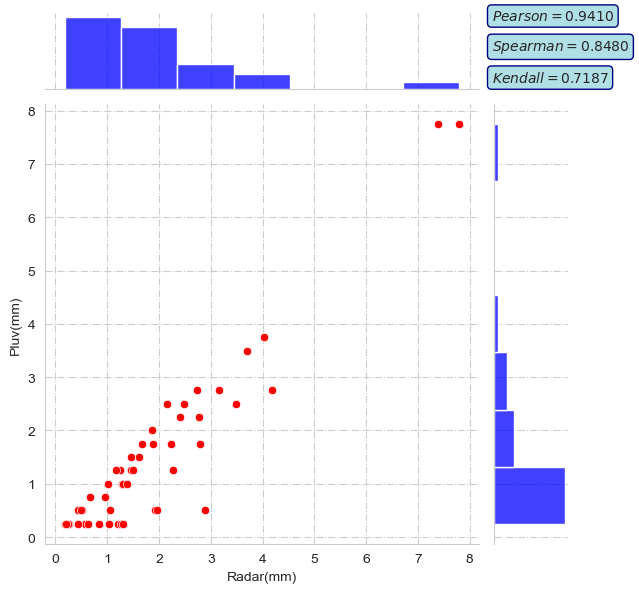

In [ ]:
ScatterPlot(Radar_mm , Pluv_mm, bins='sturges',xlab='Radar(mm)',ylab='Pluv(mm)',color='red')

Podemos notar en el gráfico de dispersión que hay dos pares atípicos localizados en la esquina superior derecha, los cuales podrían ser la causa de la cuasi-linearidad que indica la medida de dependencia de Pearson. Estos valores coinciden con los valores atípicos que se detectaron durante el análisis univariado, Sin embargo, es importante señalar que los valores atípicos encontrados en el análisis exploratorio univariado no son necesariamente valores atípicos en el análisis exploratorio bivariado, se debe evaluar la conveniencia de retirar cada par.

Para retirar los valores atípicos bivariados se hace de forma manual ubicando los valores atípicos en términos de que tan alejados están del grupo de muestras. Por ejemplo, se decide que los valores atípicos se ubican en la parte superior derecha del scatterplot, los cuales corresponden a los pares ubicados en la fila 31 y 35, se genera un nueva data frame sin esos valores usando la funcion "drop" de la siguiente forma

In [ ]:
Radar_mm_out_bi=Radar_mm.drop([31,35], axis=0, inplace=False)
Pluv_mm_out_bi=Pluv_mm.drop([31,35], axis=0, inplace=False)

Con las nuevas variables se hace el gráfico de dispersión

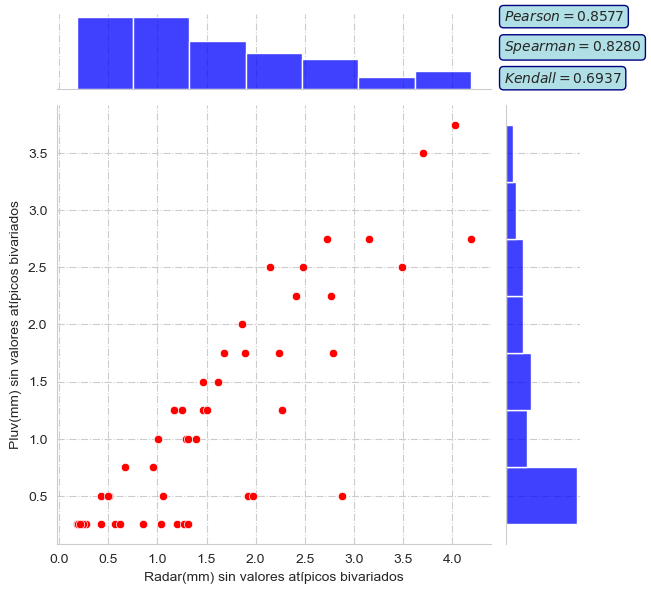

In [ ]:
ScatterPlot(Radar_mm_out_bi , Pluv_mm_out_bi, bins='sturges', xlab='Radar(mm) sin valores atípicos bivariados',
            ylab='Pluv(mm) sin valores atípicos bivariados',color='red')

Respecto a las medidas de dependencia, se puede notar que las medidas disminuyeron su valor al retirar los valores atípicos.

| Dependencia | Original | Sin outliers |
|  ------ |  -------- | -------- |
| Pearson | 0.9410 | 0.8577 |
| Spearman | 0.8480 | 0.8280|
| Kendall | 0.7187 |0.6937|

### Analisis de regresión lineal.

Como se mencionó en clase, la regresión trata de establecer relaciones funcionales entre variables aleatorias, en este caso, la relación se establece con una recta. Para hacer el análisis necesitamos de los parámetros de la recta y el análisis de residuos.

Para obtener este gráfico se usa la función "scaterplotReg", la cual necesita de los siguientes parámetros:


* Variables (Radar_mm , Pluv_mm)
* Número de intervalos para los histogramas, en este caso sigue la regla de Sturges
* Leyendas para el eje X (XLAB) y el eje Y (YLAB)
* Color del gráfico de dispersión (color)

In [ ]:
def ScatterPlotReg(x,y,xlab,ylab,bins,color):
    data_pair=pd.concat([x,y], axis=1)
    g=sns.jointplot(x=data_pair.iloc[:,0],y=data_pair.iloc[:,1],data=data_pair,kind='reg',
                    color=color,marginal_kws=dict(bins=bins,color='blue'))
    p = x.corr(y, method = "pearson")
    r = x.corr(y, method = "spearman")
    k = x.corr(y, method = "kendall")

    x1 = np.array([x]).reshape((-1, 1))
    y1 = np.array([y]).reshape((-1, 1))
    model = LinearRegression()
    model = LinearRegression().fit(x1, y1)
    r_sq = model.score(x1, y1)
    #print(f"coefficient of determination: {r_sq}")
    intercept=str(model.intercept_)
    slope=str(model.coef_)
    R2=str(r_sq)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(xmin, ymax, 'y = ' + intercept + ' + ' + slope + 'x')
    plt.text(xmin, (ymax-0.08*ymax), 'R^2 = ' + R2)
    #g.ax_joint.annotate(f'$y = {intercept:.4f}+{slope:.4f}x$',
    #                xy=(0.2, 0.8), xycoords='axes fraction',
    #                ha='left', va='center',
    #                bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(f'$Pearson = {p:.4f}$',
                    xy=(1.03, 1.2), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(f'$Spearman = {r:.4f}$',
                    xy=(1.03, 1.13), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(f'$Kendall={k:.4f}$',
                    xy=(1.03, 1.06), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    plt.xlabel(xlab)
    plt.ylabel(ylab)


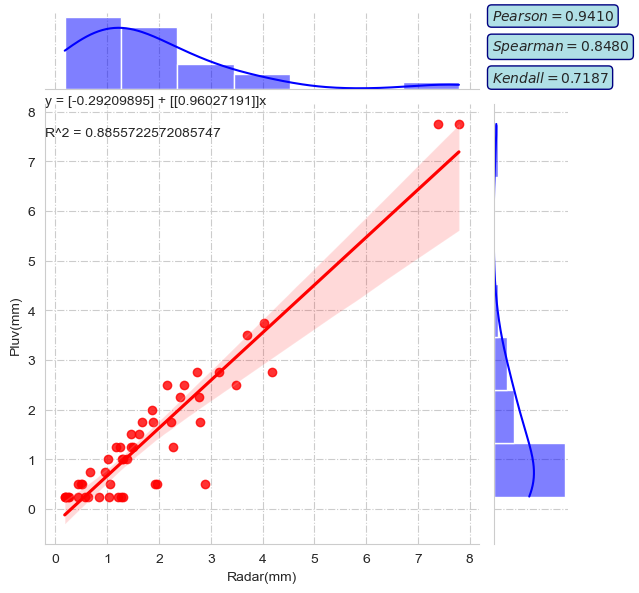

In [ ]:
ScatterPlotReg(Radar_mm , Pluv_mm, bins='sturges',xlab='Radar(mm)',ylab='Pluv(mm)',color='red')

De este grafico se requiere de los valores de la regresión lineal y su coeficiente de determinación. Para hacer la regresión lineal se usa la función "LinearRegression", esta necesita los siguientes parámetros:

* Indicar las variables x,y

In [ ]:
x = np.array([Radar_mm]).reshape((-1, 1))
y = np.array([Pluv_mm]).reshape((-1, 1))
model = LinearRegression()
model = LinearRegression().fit(x, y)

In [ ]:
r_sq = model.score(x, y)
print(f"El coeficiente de determinación es: {r_sq}")

El coeficiente de determinación es: 0.8855722572085747


Con los parámetros de la recta $B_0$ (intercepto) y $B_1$, hacemos el calculo de los residuos.

In [ ]:
print(f"El intercepto es: {model.intercept_}")

El intercepto es: [-0.29209895]


In [ ]:
print(f"El coeficiente B1 es: {model.coef_}")

El coeficiente B1 es: [[0.96027191]]


In [ ]:
y_pred = model.predict(x)

In [ ]:
Y_Residual=y-y_pred
Y_Residual=pd.Series(Y_Residual[:,0],name='Residuals')

Ya que tenemos calculados los residuos necesitamos obtener sus valores estadísticos.

In [ ]:
Y_Residual_Stat=Estadisticas(Y_Residual,lan='esp')
print(Y_Residual_Stat)

Estadisticas           Residuals
Muestras                    50.0
Mínimo                 -1.973484
1er cuartil            -0.198806
Mediana                 0.156153
Media                       -0.0
3er cuartil             0.355175
Máximo                   0.94569
Rango                   2.919174
Rango intercuartil      0.553981
Varianza                0.294721
Desviación estándar     0.542883
Simetria               -1.389475
Curtosis                2.498869
dtype: object


Y tambien necesitamos obtener el histograma de estos residuos.

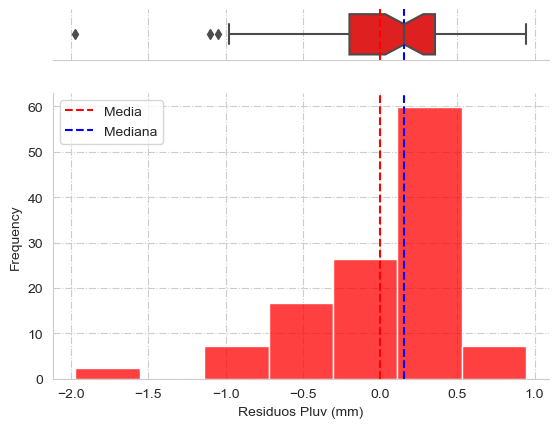

In [ ]:
HistBoxplot(x=Y_Residual,mean=Y_Residual_Stat.iloc[5],median=Y_Residual_Stat.iloc[4], bins = "sturges",
            stat='frequency',color = "red",xlab='Residuos Pluv (mm)',lan='esp')

Al analizar los valores estadísticos y el histograma de los residuos, se observa que el valor esperado es de 0, su varianza es de 0.2947 y la diferencia entre la media y la mediana es de 0.1562, lo cual nos indica que tiene asimetría negativa, por lo tanto, los residuos no cumplen con todas las condiciones que demanda la regresión lineal.

Para confirmar que los residuos no cumplen con las condiciones de la regresión lineal hay que usar los gráficos de comparación empirica y teórica, estos son el histograma, grafico cuantil-cuantil (Q-Q) y de función acumulativa (CDF).

Para el Gráfico Q-Q se usa la funcion "probplot", este gráfico muestra que unas pocas muestras intersectan la recta, por lo tanto, los residuos no muestran evidencia de normalidad.

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([-1.97348414, -1.09963671, -1.05162311, -0.98144034, -0.71585725,
         -0.67744637, -0.63771828, -0.63705967, -0.61022734, -0.55925001,
         -0.45658383, -0.27413217, -0.22578927, -0.11785423, -0.10891012,
         -0.05326963, -0.042679  , -

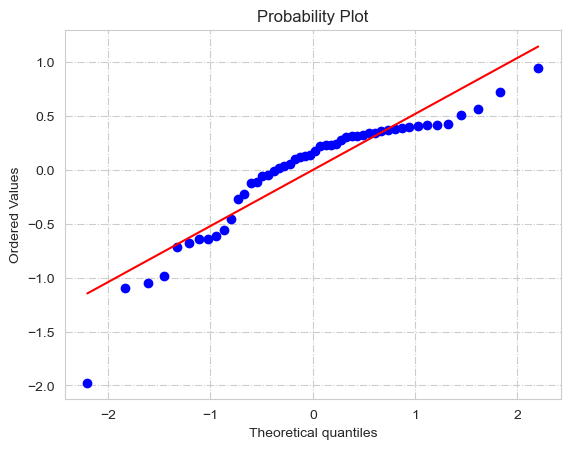

In [ ]:
stats.probplot(Y_Residual, dist="norm", plot=plt)

Para obtener el histograma de los residuos con la funcion de distribucion de probabilidad normal se grafica primero el histograma de los residuos con la funcion "hist", despues se genera la funcion de distribucion de probabilidad normal usando la funcion "pdf".

Como se puede notar, el histograma no se ajusta a la funcion de distribución, por lo tanto los residuos no muestran evidencia de normalidad.

In [ ]:
mu, std = norm.fit(Y_Residual)

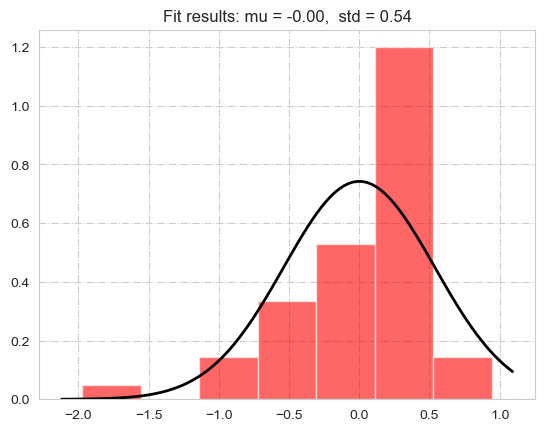

In [ ]:
plt.hist(Y_Residual, bins='sturges', density=True, alpha=0.6, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

Para obtener el gráfico con las funciones de distribución acumulativas, primero se estima la funcion acumulativa de los residuos usando la funcion "ECDF", despues se grafica la funcion de distribucion acumulativa de la distribucion normal usando la funcion "cdf".

El resultado muestra que son pocas las muestras que se intersectan con la recta de la cdf normal, por lo tanto esta grafica sugiere que los rsiduos no son normales.

Text(0.5, 1.0, 'Fit results: mu = -0.00,  std = 0.54')

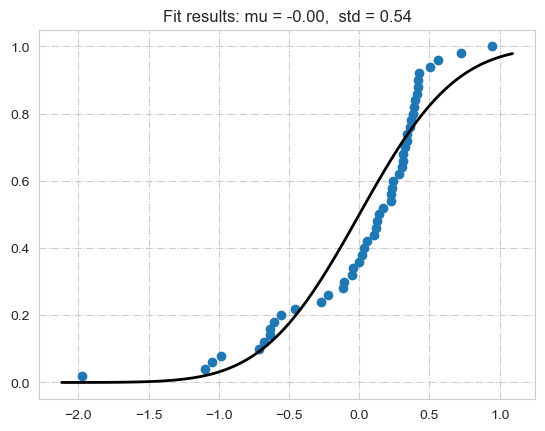

In [ ]:
ecdf = ECDF(Y_Residual)
plt.scatter(ecdf.x, ecdf.y)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.cdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

Ahora debemos aplicar una prueba de normalidad, en este caso tenemos dos opciones: hipótesis de Kolmogorov-Smirnov y la hipótesis de Anderson-Darling.

La hipótesis de Kolmogorov-Smirnov se usa para contrastar la hipótesis de normalidad, el estadístico de prueba es la máxima diferencia:

$$D=máx|F_n(x)-F_{va}(x)|$$

Donde $F_n(x)$ es la función de distribución paramétrica, en este caso la función normal. Y $F_{va}(x)$ es la función de la variable aleatoria.

In [ ]:
kstest(Y_Residual, 'norm')

KstestResult(statistic=0.2540190526813303, pvalue=0.002483915221860422, statistic_location=0.4288421457781657, statistic_sign=1)

La hipótesis de Anderson-Darling es una prueba no paramétrica que se basa en la comparación de las muestras $\textbf{Y}$ y la función de distribución de probabilidad teórica $\textbf{F}$. Su fórmula es:

$$S=\sum_{k=1}^{N}\frac{2k-1}{N}\left[ln(F(Y_k))+ln(1-F(Y_{N+1-k}))\right]$$

El valor p es una probabilidad que mide la evidencia en contra de la hipótesis nula. Un valor p más pequeño proporciona una evidencia más fuerte en contra de la hipótesis nula. esta hipótesis se usa para determinar si los datos siguen una distribución normal.

Si $p\leq a$ donde a es el nivel de significancia la decisión es rechazar la hipótesis nula y concluir que sus datos siguen una distribución normal.

Si $p>a$ donde a es el nivel de significancia la decisión es no rechazar la hipótesis nula y concluir que sus datos no tienen suficiente evidencia para concluir que los datos no siguen una distribución normal.

In [ ]:
result = anderson(Y_Residual, 'norm')
print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, las muestras parecen normales/data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, las muestras parecen normales/data looks normal (reject H0)' % (slevel, cvalues))

Statistic: 2.130
15.000: 0.538, las muestras parecen normales/data looks normal (reject H0)
10.000: 0.613, las muestras parecen normales/data looks normal (reject H0)
5.000: 0.736, las muestras parecen normales/data looks normal (reject H0)
2.500: 0.858, las muestras parecen normales/data looks normal (reject H0)
1.000: 1.021, las muestras parecen normales/data looks normal (reject H0)


### Análisis bivariado: Y vs Y residual.

Ahora necesitamos evaluar si los valores obtenidos del pluviómetro tienen una relación con los residuos, para esto necesitamos el gráfico de dispersión. El cual generamos de la siguiente forma:

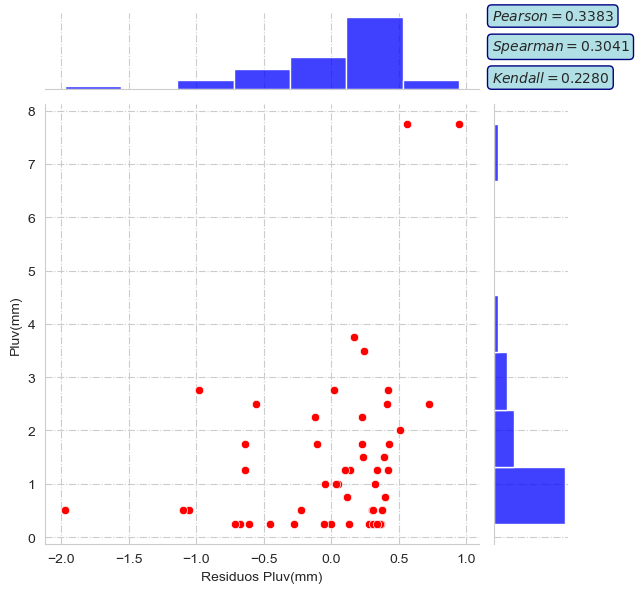

In [ ]:
ScatterPlot(Y_Residual , Pluv_mm, bins='sturges',xlab='Residuos Pluv(mm)',ylab='Pluv(mm)',color='red')

En este grafico podemos notar que la medida de dependencia lineal de Pearson es de 0.339, Spearman es de 0.3041 y Kendall es de 0.228. Esto nos da como conclusión que la regresión lineal no cumple con la condición no correlación entre los residuos y las muestras del pluviómetro.

## Análisis estadístico bivariado con variables transformadas.

Ahora haremos el caso donde las variables (Radar_mm, Pluv_mm) tienen transformada logarítmica. Se escogió que las variables aleatorias usen esta transformación por los resultados que se tuvieron con la variable aleatoria de las muestras obtenidas con el pluviómetro.

### Grafico de dispersión.

En el gráfico de dispersión podemos notar que las medidas de dependencia tienen los siguientes valores:

* Spearman (0.848)
* Kendall (0.7187)
* Pearson (0.8256)

Si comparamos las medidas de dependencia de este análisis estadístico bivariado con el anterior análisis podemos notar que el coeficiente de correlación de Pearson cambió de 0.9410 a 0.8256, mientras que los coeficientes de Spearman y Kendall se mantuvieron. Esto muestra una gran ventaja al usar los coeficientes de Spearman y Kendall ya que no se ven afectados ante transformaciones.

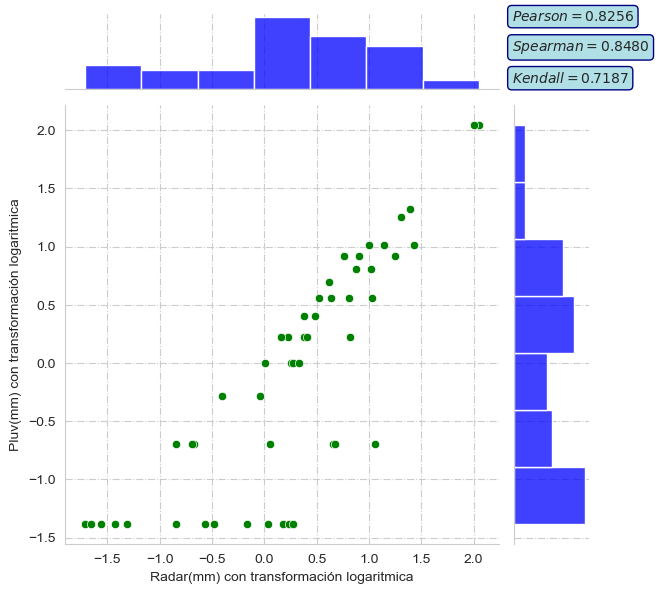

In [ ]:
ScatterPlot(Radar_mm_Log , Pluv_mm_Log, bins='sturges',xlab='Radar(mm) con transformación logaritmica',
            ylab='Pluv(mm) con transformación logaritmica',color='green')

### Análisis de regresión lineal.

Ahora obtendremos los valores de la regresión lineal.

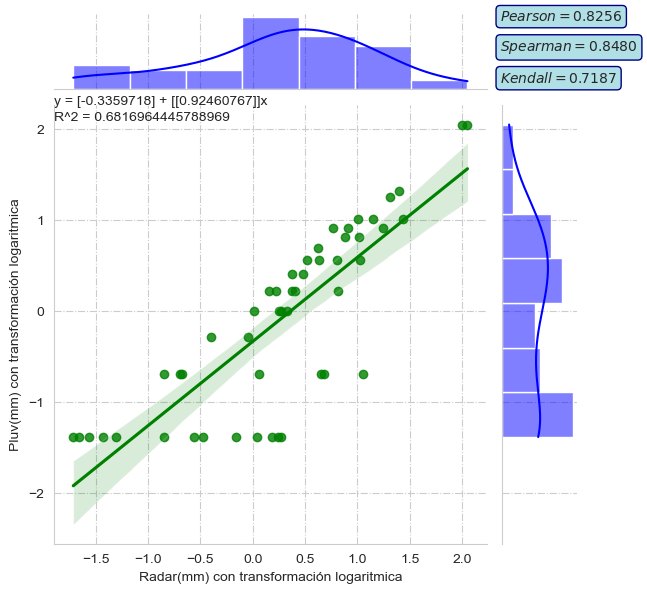

In [ ]:
ScatterPlotReg(Radar_mm_Log , Pluv_mm_Log, bins='sturges',xlab='Radar(mm) con transformación logaritmica',
            ylab='Pluv(mm) con transformación logaritmica',color='green')

In [ ]:
x_Log = np.array([Radar_mm_Log]).reshape((-1, 1))
y_Log = np.array([Pluv_mm_Log]).reshape((-1, 1))
model_Log = LinearRegression()
model_Log = LinearRegression().fit(x_Log, y_Log)

In [ ]:
r_sq_Log = model_Log.score(x_Log, y_Log)
print(f"El coeficiente de determinación es: {r_sq_Log}")

El coeficiente de determinación es: 0.6816964445788969


Con los parámetros de la recta $B_0$ (intercepto) y $B_1$, hacemos el calculo de los residuos.

In [ ]:
print(f"El intercepto es: {model_Log.intercept_}")

El intercepto es: [-0.3359718]


In [ ]:
print(f"El coeficiente B1 es: {model_Log.coef_}")

El coeficiente B1 es: [[0.92460767]]


In [ ]:
y_pred_Log = model_Log.predict(x_Log)

In [ ]:
Y_Residual_Log=y_Log-y_pred_Log
Y_Residual_Log=pd.Series(Y_Residual_Log[:,0],name='Residuals')

El grafico Q-Q plot también muestra que pocas muestras están en la recta

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([-1.33521639, -1.29999172, -1.27131942, -1.21889847, -1.08658633,
         -0.98409039, -0.96032025, -0.90005631, -0.60832699, -0.5305831 ,
         -0.41105126, -0.26998136, -0.19885936, -0.05309834,  0.02288663,
          0.03149503,  0.08603406,  

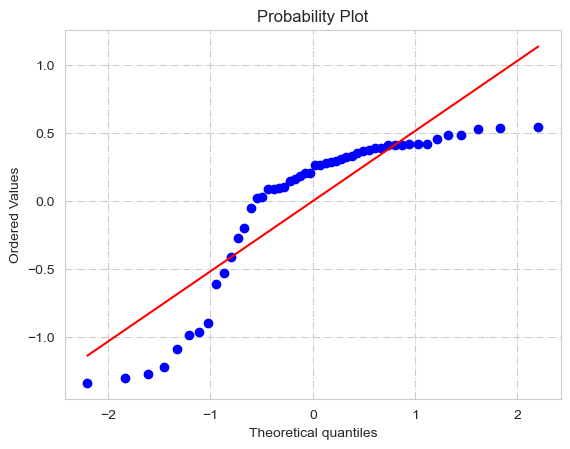

In [ ]:
stats.probplot(Y_Residual_Log, dist="norm", plot=plt)

Como se puede notar, el histograma no se ajusta a la funcion de distribución, por lo tanto los residuos no muestran evidencia de normalidad.

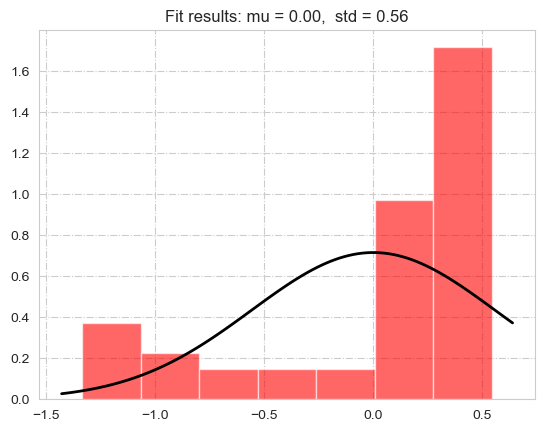

In [ ]:
plt.hist(Y_Residual_Log, bins='sturges', density=True, alpha=0.6, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(Y_Residual_Log)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

El resultado muestra que son pocas las muestras que se intersectan con la recta de la cdf normal, por lo tanto esta grafica sugiere que los residuos no son normales.

Text(0.5, 1.0, 'Fit results: mu = 0.00,  std = 0.56')

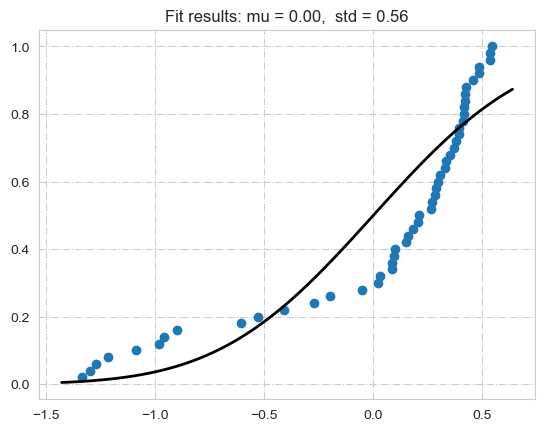

In [ ]:
ecdf_Log = ECDF(Y_Residual_Log)
plt.scatter(ecdf_Log.x, ecdf_Log.y)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.cdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

Ahora debemos aplicar una prueba de normalidad, en este caso tenemos dos opciones: hipótesis de Kolmogorov-Smirnov y la hipótesis de Anderson-Darling.

In [ ]:
kstest(Y_Residual_Log, 'norm')

KstestResult(statistic=0.29304697031046834, pvalue=0.00026747992245492163, statistic_location=0.5445050988630644, statistic_sign=1)

La hipótesis de Anderson-Darling indica que las muestras no son normales.

In [ ]:
result = anderson(Y_Residual_Log, 'norm')
print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, las muestras parecen normales/data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, las muestras no parecen normales/data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 4.242
15.000: 0.538, las muestras no parecen normales/data does not look normal (reject H0)
10.000: 0.613, las muestras no parecen normales/data does not look normal (reject H0)
5.000: 0.736, las muestras no parecen normales/data does not look normal (reject H0)
2.500: 0.858, las muestras no parecen normales/data does not look normal (reject H0)
1.000: 1.021, las muestras no parecen normales/data does not look normal (reject H0)


### Análisis bivariado: Y vs Y residual.

Ahora necesitamos evaluar si los valores obtenidos del pluviómetro con transformación logaritmica tienen una relación con los residuos, para esto necesitamos el gráfico de dispersión. El cual generamos de la siguiente forma:

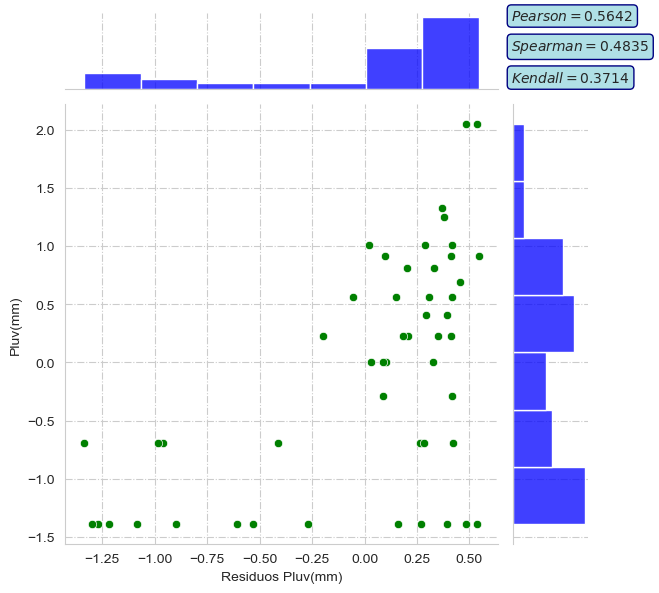

In [ ]:
ScatterPlot(Y_Residual_Log , Pluv_mm_Log, bins='sturges',xlab='Residuos Pluv(mm)',ylab='Pluv(mm)',color='green')

El resultado de las medidas de dependencia muestra que la dependencia es considerable. Pearson tiene un valor de 0.5702, Spearman es de 0.4971 y Kendall es de 0.3818. Con esta última prueba podemos concluir que la regresión lineal usando las variables aleatorias transformadas no cumplió con ninguna de las condiciones.

Con el caso de las muestras obtenidas de los pluviómetros, podemos ver que los valores atípicos se localizan en los mismos lugares de los valores atípicos obtenidos del radar meteorológico, por lo que debemos tomar en cuenta esta información para el análisis variografico.

# Análisis variográfico.

In [ ]:
def HistBoxplot(x,mean,median,bins,stat,color,xlab,lan):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                    gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x,orient='h',color=color,notch=True, ax=ax_box)
    ax_box.axvline(mean, ymin = 0, ymax = 1,color='red', linestyle = "dashed")
    ax_box.axvline(median, ymin = 0, ymax = 1,color='blue', linestyle = "dashed")
    sns.set_style("whitegrid", {'grid.linestyle': '-.'})
    sns.histplot(x, bins = bins,stat=stat,color=color, ax=ax_hist)
    ax_hist.axvline(mean, ymin = 0, ymax = 1,color='red', linestyle = "dashed")
    ax_hist.axvline(median, ymin = 0, ymax = 1,color='blue', linestyle = "dashed")
    plt.xlabel(xlab)
    if lan=='esp':
        plt.legend(labels=["Media", "Mediana"])
    if lan=='eng':
        plt.legend(labels=["Mean", "Median"])
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

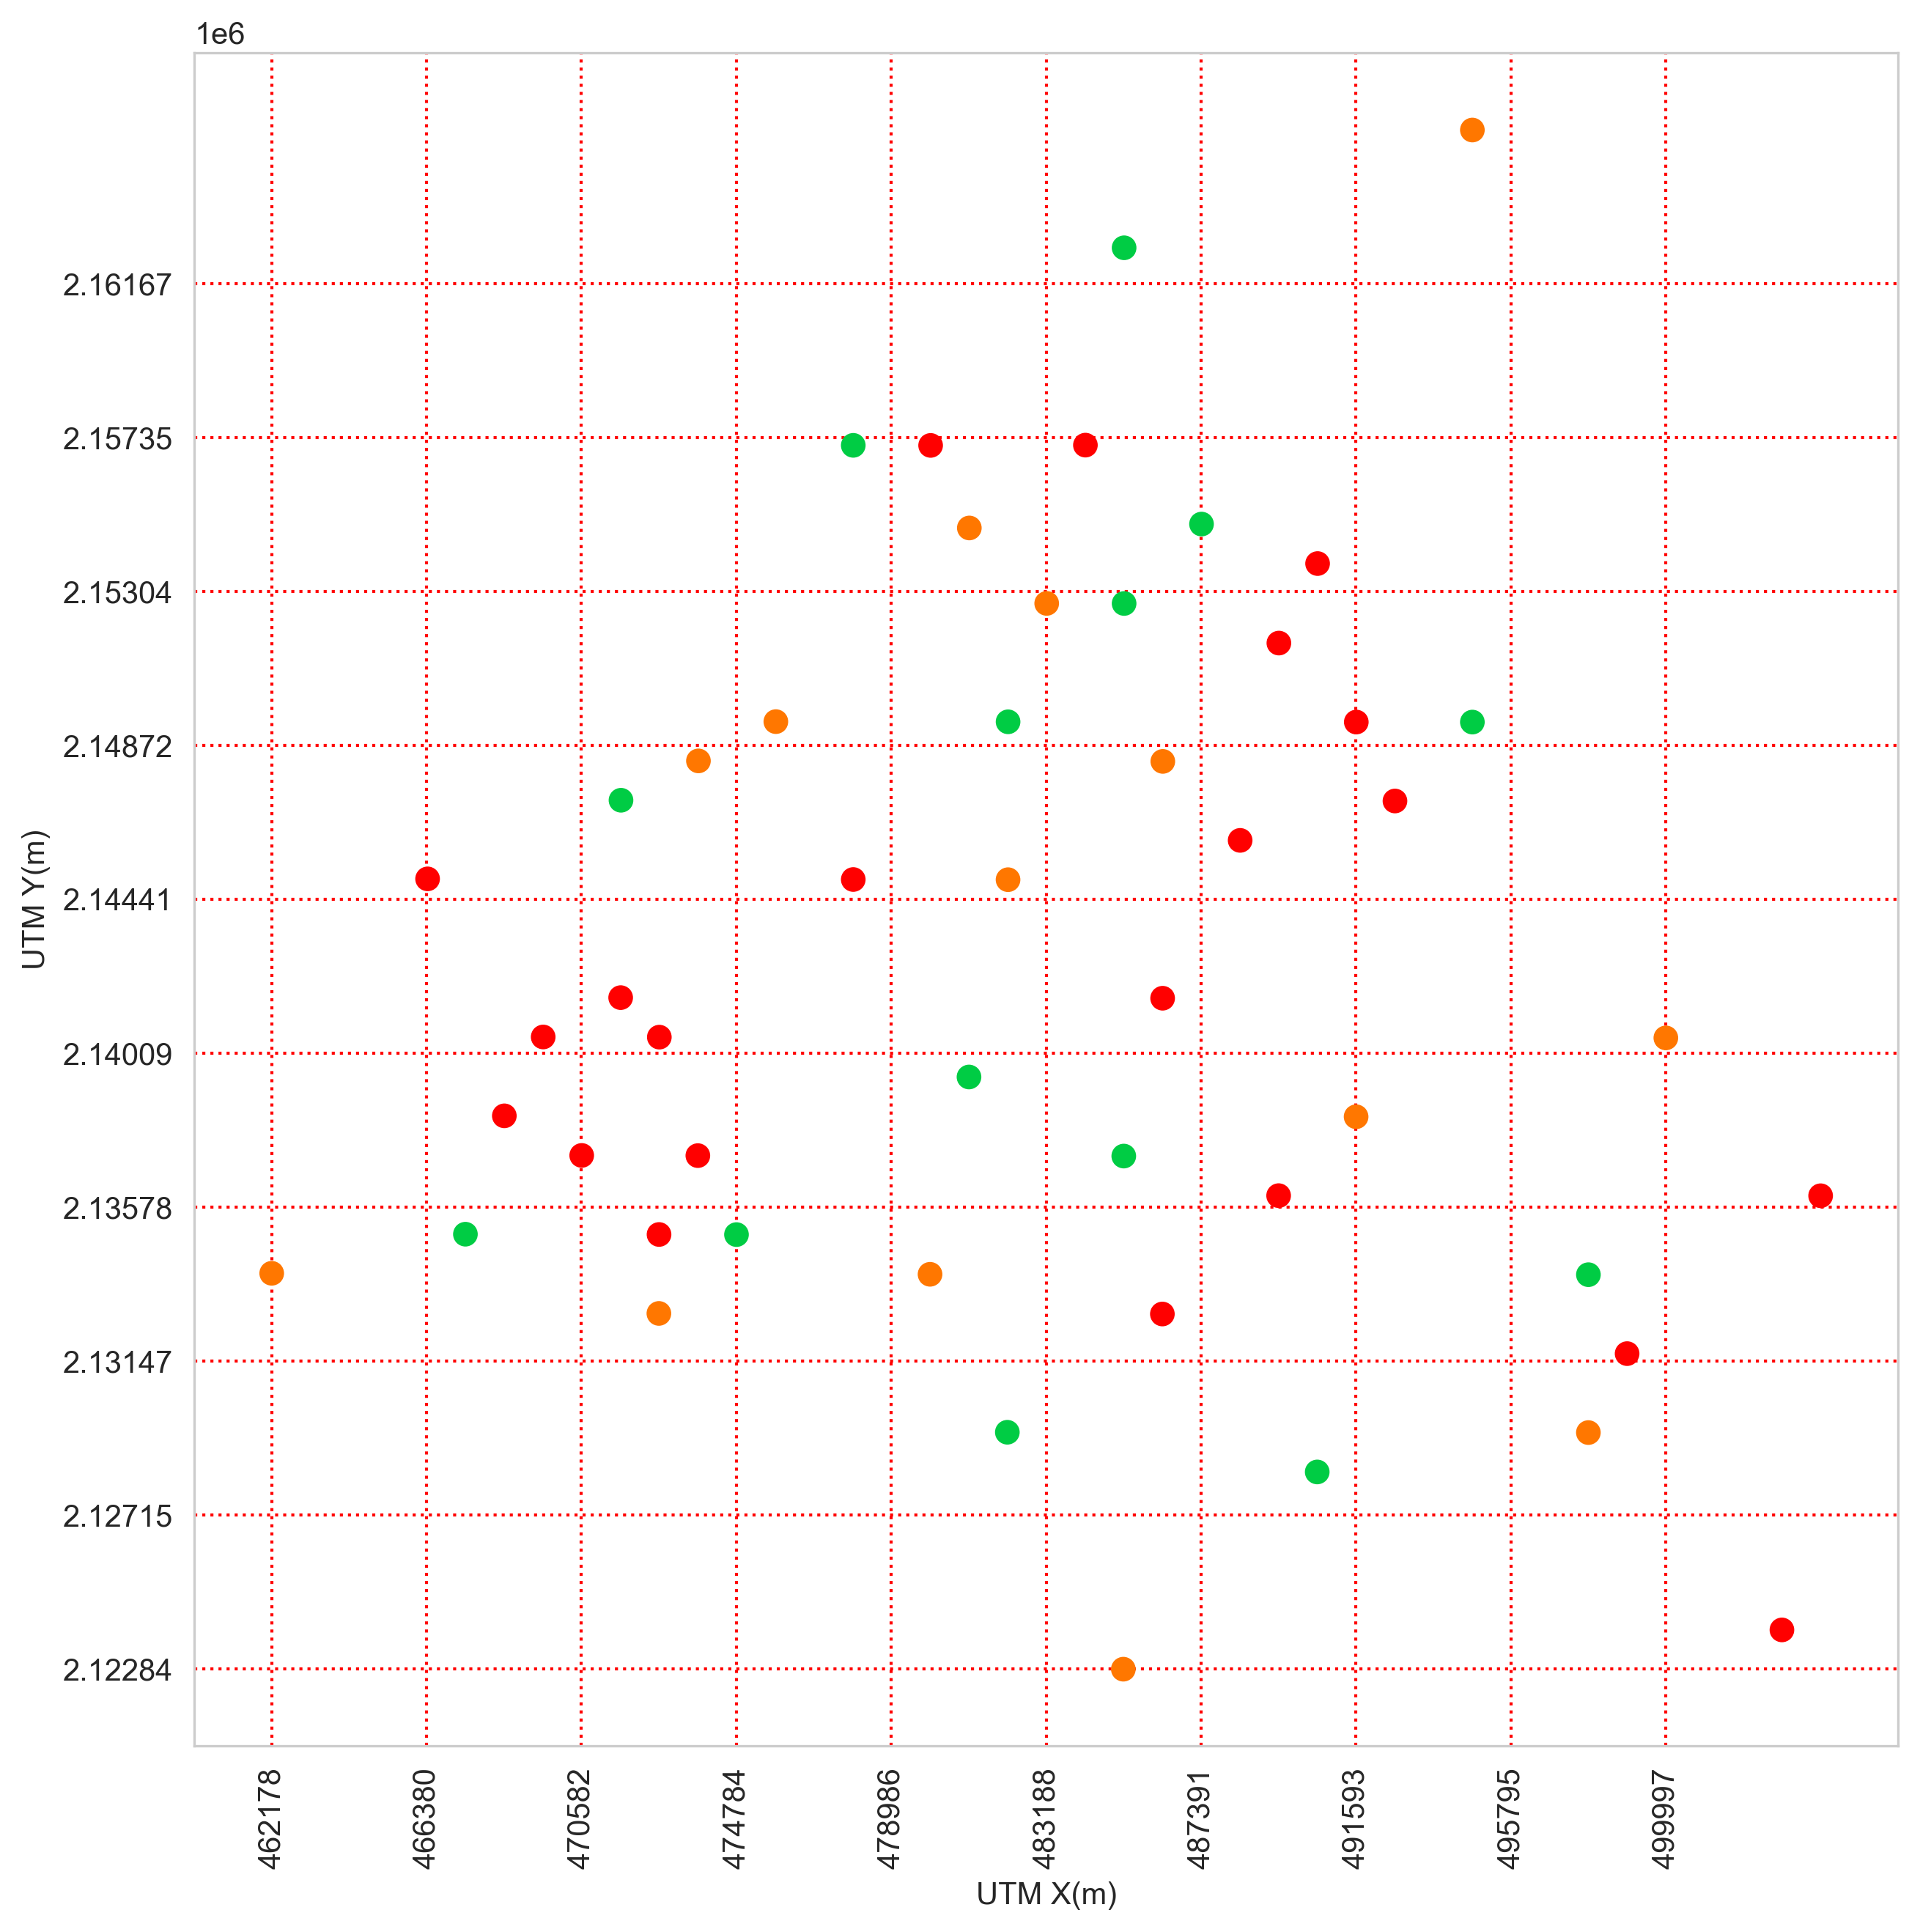

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
v = np.random.randint(0, 3, size=len(XCoord))
colores = ["#00cc44",  # Verde
           "#ff7700",  # Naranja
           "#ff0000"   # Rojo
          ]
plt.scatter(
    x=XCoord,
    y=YCoord,
    s=50,
    c=np.take(colores, v)
    )
plt.xlabel("UTM X(m)")
plt.ylabel("UTM Y(m)")
minor_ticks_x = np.arange(min(XCoord), max(XCoord), (max(XCoord)-min(XCoord))/10)
minor_ticks_y = np.arange(min(YCoord), max(YCoord), (max(YCoord)-min(YCoord))/10)

#ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks_x, minor=False)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks_y, minor=False)
plt.xticks(rotation=90)
plt.grid( color='r', linestyle='dotted', linewidth=1)